# FastAI Transfer Learning for Image Multicategorial Problem

The task:

recognizing millions of objects in pictures using the renowned Microsoft COCO dataset.

train set has 97774 images and there are 80 Categories.

step 1 download the data from kaggle

In [2]:
import pathlib
path = pathlib.Path('/storage/archive/hbku2019')
path

PosixPath('/storage/archive/hbku2019')

In [8]:
from kaggle import api
if not path.exists():
    path.mkdir()
    api.competition_download_cli('hbku2019', path=path)

  0%|          | 3.00M/5.13G [00:00<04:04, 22.5MB/s]

100%|██████████| 5.13G/5.13G [03:10<00:00, 28.9MB/s]

In [9]:
import zipfile
with zipfile.ZipFile(path/'hbku2019.zip', 'r') as zip_ref:
    zip_ref.extractall(path)
list(path.glob('*'))

[PosixPath('/storage/archive/hbku2019/imgs.zip'),
 PosixPath('/storage/archive/hbku2019/Cocos_Baseline_v1.ipynb'),
 PosixPath('/storage/archive/hbku2019/hbku2019.zip'),
 PosixPath('/storage/archive/hbku2019/Cocos_Baseline.ipynb'),
 PosixPath('/storage/archive/hbku2019/labels.zip')]

In [10]:
with zipfile.ZipFile(path/'labels.zip', 'r') as zip_ref:
    zip_ref.extractall(path)
list(path.glob('*'))

[PosixPath('/storage/archive/hbku2019/imgs.zip'),
 PosixPath('/storage/archive/hbku2019/Cocos_Baseline_v1.ipynb'),
 PosixPath('/storage/archive/hbku2019/labels'),
 PosixPath('/storage/archive/hbku2019/hbku2019.zip'),
 PosixPath('/storage/archive/hbku2019/Cocos_Baseline.ipynb'),
 PosixPath('/storage/archive/hbku2019/labels.zip')]

In [11]:
with zipfile.ZipFile(path/'imgs.zip', 'r') as zip_ref:
    zip_ref.extractall(path)
list(path.glob('*'))

[PosixPath('/storage/archive/hbku2019/imgs.zip'),
 PosixPath('/storage/archive/hbku2019/Cocos_Baseline_v1.ipynb'),
 PosixPath('/storage/archive/hbku2019/labels'),
 PosixPath('/storage/archive/hbku2019/imgs'),
 PosixPath('/storage/archive/hbku2019/hbku2019.zip'),
 PosixPath('/storage/archive/hbku2019/Cocos_Baseline.ipynb'),
 PosixPath('/storage/archive/hbku2019/labels.zip')]

[PosixPath('/storage/archive/hbku2019/imgs/train/000000116723.jpg'), PosixPath('/storage/archive/hbku2019/imgs/train/000000046593.jpg'), PosixPath('/storage/archive/hbku2019/imgs/train/000000090532.jpg'), PosixPath('/storage/archive/hbku2019/imgs/train/000000043228.jpg'), PosixPath('/storage/archive/hbku2019/imgs/train/000000063289.jpg')]


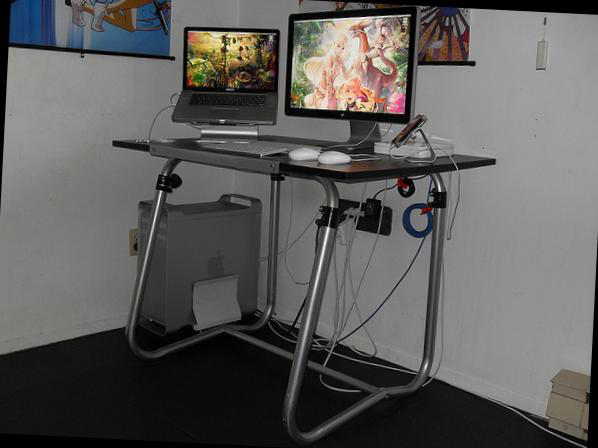

In [3]:
# explore the images and show one image
path_image = path/'imgs/train'
print(list(path_image.glob('*'))[0:5])
from PIL import Image
def show_image(path):
    image = Image.open(path)
    return image
show_image('/storage/archive/hbku2019/imgs/train/000000116723.jpg')

In [16]:
path_label = path/'labels/'
list(path_label.glob('*'))

[PosixPath('/storage/archive/hbku2019/labels/categories.csv'),
 PosixPath('/storage/archive/hbku2019/labels/labels_train.csv')]

In [4]:
# explore the labels files
with open(path/'labels/categories.csv') as x:
    categories = x.read().split("\n")[:-1]
df_header = ["img_id"] + categories
print(len(df_header), df_header[1:5])

import pandas as pd
df = pd.read_csv(path/'labels/labels_train.csv', sep=',', header=None, names=df_header)
print(df.shape)
df.head()

81 ['person', 'bicycle', 'car', 'motorcycle']
(97774, 81)


,img_id,person,bicycle,car,motorcycle,airplane,bus,train,truck,boat,...,toaster,sink,refrigerator,book,clock,vase,scissors,teddy bear,hair drier,toothbrush
0,000000000001.jpg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,000000000002.jpg,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,000000000004.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,000000000005.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,000000000006.jpg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


['person', 'sports ball', 'tennis racket']
000000033292.jpg


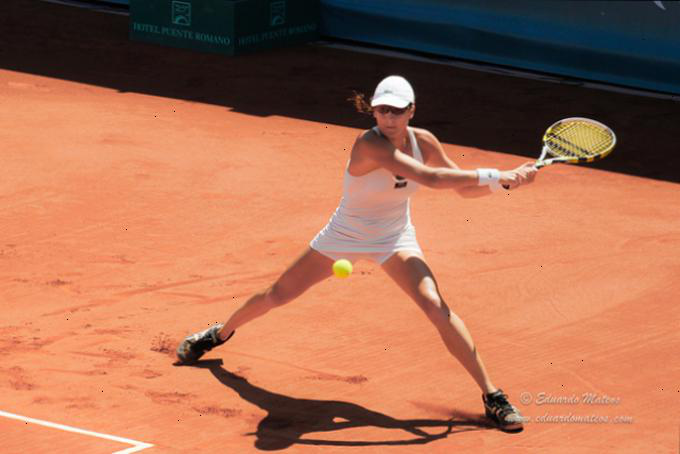

In [5]:
# check that our df is OK and the image actually has the correspond categories.
one_row = df.iloc[26580].to_list()
one_row_cat = [categories[index-1] for index, num in enumerate(one_row) if num == 1.0]
print(one_row_cat)
print(one_row[0])
show_image(f'/storage/archive/hbku2019/imgs/train/{one_row[0]}')

In [6]:
from fastai.vision.all import *

**from df to dataset using fastai DataBlock** 

To build the datablock we mention that the X is an image, and Y is MultiCategory so datablock will convert the categories in each image to appropriate one-hot-vector.

In addition each image will undergo data augmentation and resize to 128*128.

In [7]:
def get_x(r): 
    return path_image/r['img_id']
def get_y(r): 
    one_row = r.to_list()
    return [categories[index-1] for index, num in enumerate(one_row) if num == 1.0]

dblock = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   splitter=RandomSplitter(seed=42),
                   get_x=get_x, 
                   get_y=get_y,
                   item_tfms = Resize(360),
                   batch_tfms=aug_transforms(size=128, min_scale=0.75))

dsets = dblock.datasets(df)
dsets.train[0]

(PILImage mode=RGB size=277x370,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]))

In [8]:
print(dsets.train.vocab)
print(len(dsets.train))
print(len(dsets.valid))

['airplane', 'apple', 'backpack', 'banana', 'baseball bat', 'baseball glove', 'bear', 'bed', 'bench', 'bicycle', 'bird', 'boat', 'book', 'bottle', 'bowl', 'broccoli', 'bus', 'cake', 'car', 'carrot', 'cat', 'cell phone', 'chair', 'clock', 'couch', 'cow', 'cup', 'dining table', 'dog', 'donut', 'elephant', 'fire hydrant', 'fork', 'frisbee', 'giraffe', 'hair drier', 'handbag', 'horse', 'hot dog', 'keyboard', 'kite', 'knife', 'laptop', 'microwave', 'motorcycle', 'mouse', 'orange', 'oven', 'parking meter', 'person', 'pizza', 'potted plant', 'refrigerator', 'remote', 'sandwich', 'scissors', 'sheep', 'sink', 'skateboard', 'skis', 'snowboard', 'spoon', 'sports ball', 'stop sign', 'suitcase', 'surfboard', 'teddy bear', 'tennis racket', 'tie', 'toaster', 'toilet', 'toothbrush', 'traffic light', 'train', 'truck', 'tv', 'umbrella', 'vase', 'wine glass', 'zebra']
78220
19554


In [9]:
dls = dblock.dataloaders(df, bs = 128)

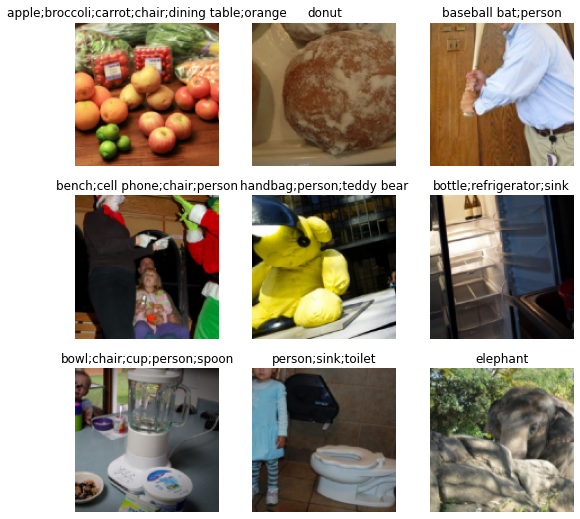

In [12]:
#check the dls
dls.show_batch(nrows=3, ncols=3)

In order to test the model we have written different functions to measure its quality.

**accuracy_multi -** checks for each category whether we were right. Disadvantage- Because most of the images have few categories, a model that predicts that there is nothing in each image will be very accurate.

**positive_from_positive -** checks out all the categories in the image, how many we found. Disadvantage- model that predicts that all categories are in each image will be perfect.

**positive_from_negative -** checks out the categories that do not appear in the image how many we predict that is appear.

so we want high positive_from_positive and low positive_from_negative.

In [13]:
def accuracy_multi(inp, targ, thresh=0.5, sigmoid=True):
    "Compute accuracy when `inp` and `targ` are the same size."
    if sigmoid: inp = inp.sigmoid()
    return ((inp>thresh)==targ.bool()).float().mean()

def positive_from_positive(inp, targ, thresh=0.5, sigmoid=True):
    if sigmoid: 
        inp = inp.sigmoid()
    mask = targ > 0.0
    new_inp = inp[mask]
    new_targ = targ[mask]
    return ((new_inp>thresh)==new_targ.bool()).float().mean()

def positive_from_negative(inp, targ, thresh=0.5, sigmoid=True):
    if sigmoid: 
        inp = inp.sigmoid()
    mask = targ == 0.0
    new_inp = inp[mask]
    new_targ = targ[mask]
    return ((new_inp>thresh)!=new_targ.bool()).float().mean()

Load pretraind model resnet34. 

Use the default loss function (Binary CrossEntropyLoss) and optimizer (Adam) 

for 3 epoch update only the last layer and for another 5 epochs update all the model.

In [14]:
from fastai.callback.fp16 import *
learn = cnn_learner(dls, resnet34, metrics=[accuracy_multi, positive_from_positive, positive_from_negative]).to_fp16()
print(learn.loss_func)
print(learn.opt_func)
learn.fine_tune(4, base_lr=3e-3, freeze_epochs=2)

FlattenedLoss of BCEWithLogitsLoss()
<function Adam at 0x7fc308d4f430>


epoch,train_loss,valid_loss,accuracy_multi,positive_from_positive,positive_from_negative,time
0,0.113605,0.089071,0.971628,0.310297,0.003308,06:53
1,0.083201,0.074337,0.974707,0.405901,0.003723,05:19


epoch,train_loss,valid_loss,accuracy_multi,positive_from_positive,positive_from_negative,time
0,0.077080,0.069319,0.976017,0.462304,0.004503,06:40
1,0.072235,0.066180,0.977064,0.498504,0.004787,06:42
2,0.067027,0.063036,0.978167,0.517835,0.004371,06:42
3,0.063438,0.062281,0.978456,0.527527,0.004437,06:40


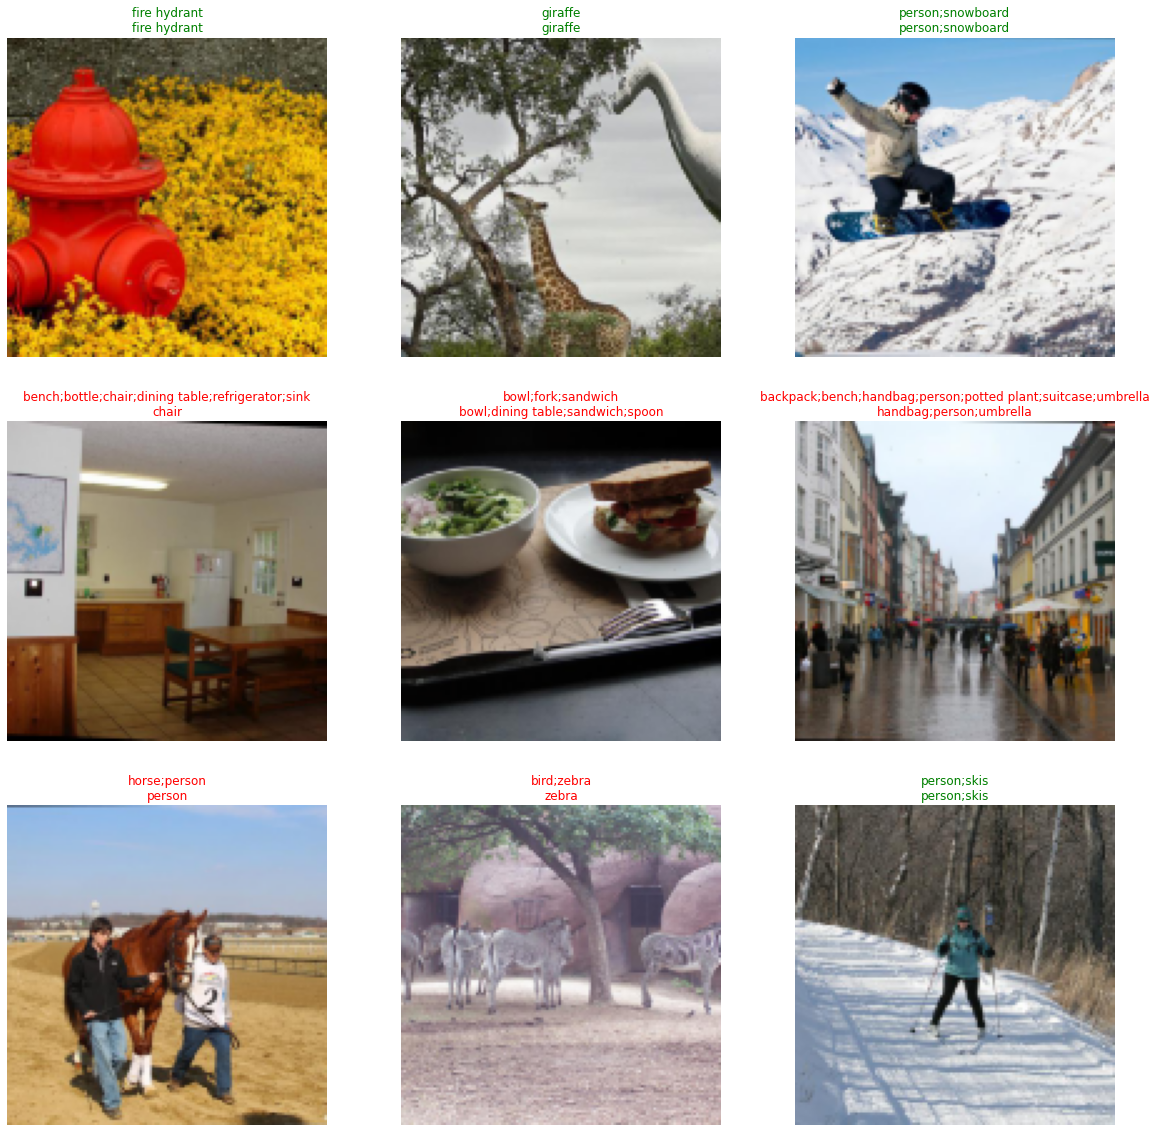

In [18]:
# The first line is the true labels, and the second is the prediction.
# The images are from the validation set.
learn.show_results(ds_idx=1, nrows=3, ncols=3, figsize=(20,20))

# Picking a threshold



In [19]:
preds,targs = learn.get_preds()

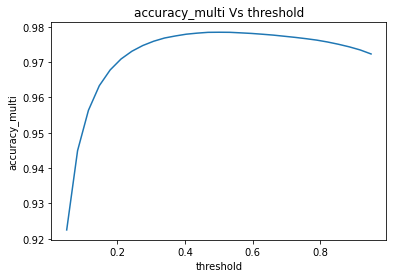

In [36]:
xs = torch.linspace(0.05,0.95,29)
accs = [accuracy_multi(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.xlabel("threshold")
plt.ylabel("accuracy_multi")
plt.title("accuracy_multi Vs threshold")
plt.plot(xs,accs)

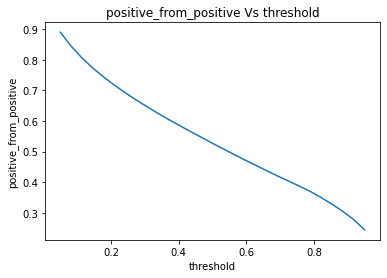

In [35]:
xs = torch.linspace(0.05,0.95,29)
positive_from_positive_accs = [positive_from_positive(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.xlabel("threshold")
plt.ylabel("positive_from_positive")
plt.title("positive_from_positive Vs threshold")
plt.plot(xs,positive_from_positive_accs);

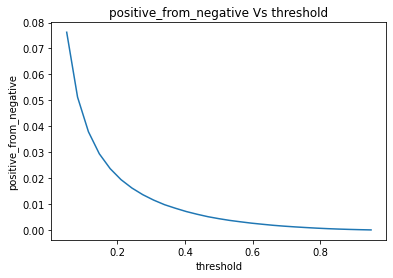

In [34]:
xs = torch.linspace(0.05,0.95,29)
positive_from_negative_accs = [positive_from_negative(preds, targs, thresh=i, sigmoid=False) for i in xs]
plt.xlabel("threshold")
plt.ylabel("positive_from_negative")
plt.title("positive_from_negative Vs threshold")
plt.plot(xs,positive_from_negative_accs);

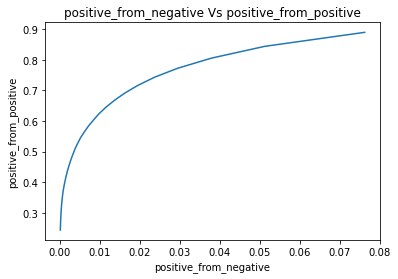

In [33]:
plt.xlabel("positive_from_negative")
plt.ylabel("positive_from_positive")
plt.title("positive_from_negative Vs positive_from_positive")
plt.plot(positive_from_negative_accs,positive_from_positive_accs);